<a href="https://colab.research.google.com/github/prokaj/elte-python-2024/blob/main/2024-12-11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [1]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [2]:
from tqdm.auto import tqdm

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
60000


In [4]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [5]:

example = next(iter(train.batch(64).take(1).as_numpy_iterator()))
image, label = example['image'], example['label']

In [6]:
example.keys(), type(example)

(dict_keys(['image', 'label']), dict)

(8, 8, 28, 28)


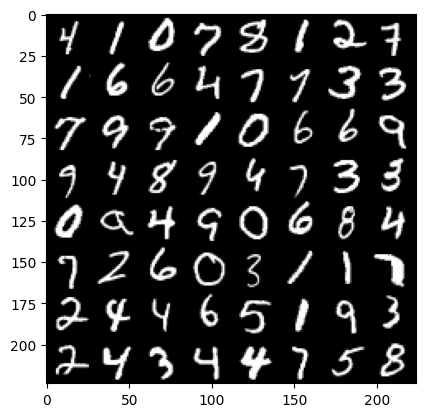

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [8]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik.

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva.
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra.


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani.


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni.

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [9]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax
    # [cpu]


In [11]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [ ]:
import jax
import jax.numpy as jnp

In [12]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [14]:
image.shape

(64, 28, 28, 1)

In [16]:
x = image[0]
print(x.shape)
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')

(28, 28, 1)
[-1006.25917351  1010.52233305  -273.82761385 -1479.84560519
   401.24677097   767.82750364  -691.65967151  -849.72680309
   542.02506939  1043.72716107]
A képen 9 van?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [17]:
image[0].max()

255

In [18]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[ 0.14672857  0.48710599 -0.26943265 -0.32589935  0.8238393   1.45072737
  0.43413401 -0.11134322  0.32495918 -0.86462963]
A képen 5 van?


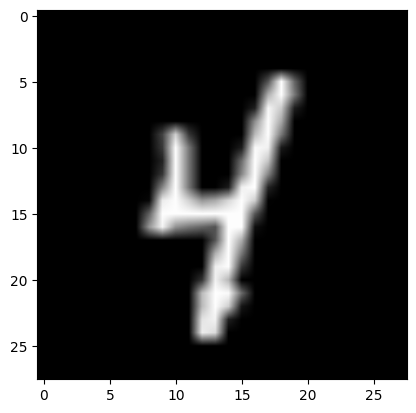

In [19]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x.squeeze(), cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [20]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [21]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[ 0.14672857  0.48710599 -0.26943265 -0.32589935  0.8238393   1.45072737
  0.43413401 -0.11134322  0.32495918 -0.86462963]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-2.5653281 -2.2249508 -2.9814894 -3.0379562 -1.8882174 -1.2613294
 -2.2779226 -2.8234    -2.3870976 -3.5766864]
loss:	1.8882173299789429


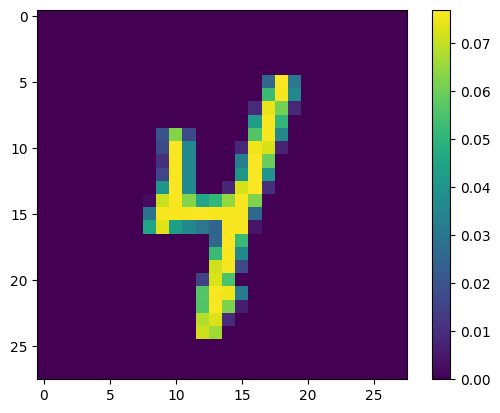

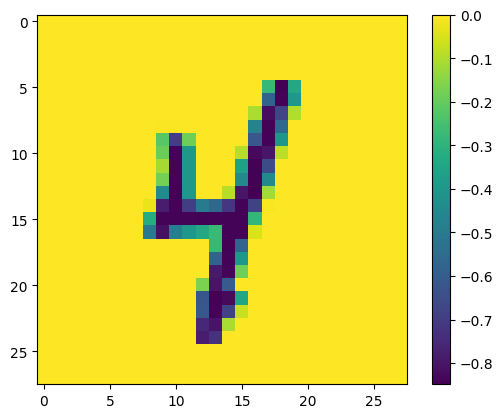

In [22]:
def L(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(L)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [23]:
batch_L = jax.vmap(L, in_axes=None)
batch_L(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


Array([1.7559397, 1.8341454, 2.354833 , 3.076091 , 2.7037542, 1.8337774,
       2.7457952, 3.0746193, 1.8332278, 2.3557003, 2.3535323, 1.7561626,
       3.075517 , 3.0763721, 3.0058556, 3.0050597], dtype=float32)

In [29]:
def loss_fn(theta, x, y):
    return batch_L(theta, x=x, y=y).mean(axis=0)

loss_fn = jax.value_and_grad(loss_fn)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = loss_fn(theta, x=x, y=y)
    return loss, jax.tree.map(lambda t, g: t-eta*g, theta, gradient)

In [31]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, theta0 = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [27]:
theta0

(Array([ 0.48208278,  1.0123144 ,  0.09554099, -0.1574702 ,  1.0844375 ,
         1.2866962 ,  0.49061376, -0.21743567,  0.13222061, -0.5629386 ],      dtype=float32),
 Array([[-0.04717926,  0.02168291,  0.05464529, ...,  0.00078168,
         -0.00644963, -0.02651726],
        [-0.03712938,  0.0367313 , -0.00924641, ..., -0.02289216,
          0.08625516,  0.07391825],
        [ 0.02882687,  0.0853728 , -0.0223048 , ..., -0.00481776,
          0.02499611, -0.01571647],
        ...,
        [ 0.04318887, -0.02450316, -0.02282606, ...,  0.02144619,
          0.0782971 ,  0.0014811 ],
        [-0.06922105, -0.03838297,  0.0448798 , ..., -0.01042678,
          0.0190618 ,  0.02733386],
        [-0.01516324, -0.02671512,  0.00028955, ...,  0.01265588,
          0.02247035,  0.02643144]], dtype=float32))

In [32]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.1
losses = []

for i, example in tqdm(enumerate(train.repeat().shuffle(10000).batch(256).take(2000).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    if (i+1) % 200==0:
        eta *= 0.5

0it [00:00, ?it/s]

In [33]:
eta

9.765625e-05

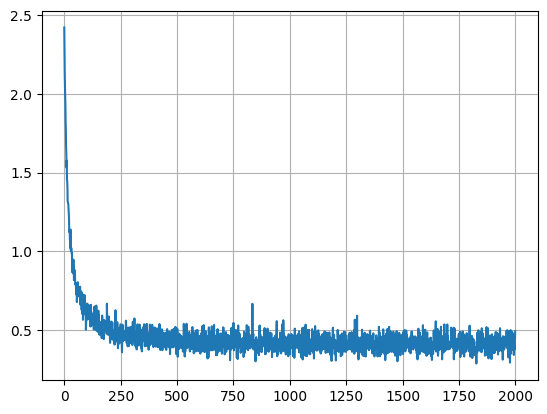

In [34]:
plt.plot(losses)
plt.grid()
plt.show()

In [35]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [36]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred,
            y_true=y_true,
            labels=classes
            ),
            columns=classes,
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [37]:
preds = []
labels = []
for example in test.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('test tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

test tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,910,0,6,4,1,11,11,1,14,1
1,1,1091,7,7,1,5,1,3,12,1
2,8,13,861,10,23,2,25,24,30,3
3,7,4,25,893,1,36,4,11,22,14
4,2,11,11,0,900,1,9,1,6,46
5,23,10,9,41,21,718,15,8,48,19
6,5,5,13,3,11,15,929,0,7,0
7,8,19,17,2,18,0,0,962,1,30
8,7,33,23,40,9,19,8,6,807,21


In [38]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('train tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)


train tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4756,0,27,18,12,31,51,5,55,9
1,0,5411,28,23,3,46,11,12,71,8
2,51,79,4206,90,105,14,119,102,153,40
3,30,42,137,4389,6,207,47,77,117,62
4,12,25,36,5,4372,4,57,14,45,285
5,87,66,41,218,76,3620,97,26,193,85
6,43,23,67,3,37,75,4622,4,53,3
7,43,82,83,19,74,10,3,4674,19,201
8,27,145,71,162,20,143,42,31,4132,105


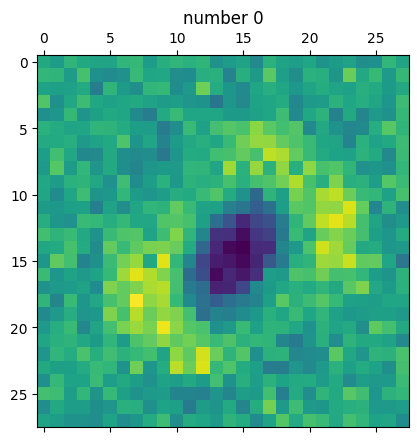

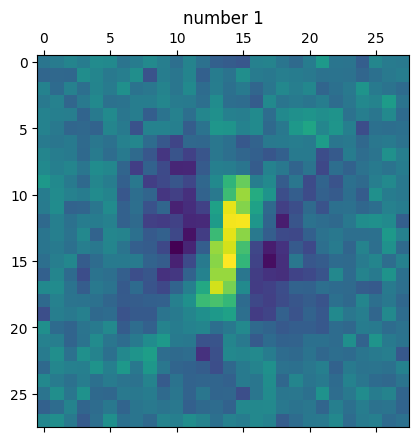

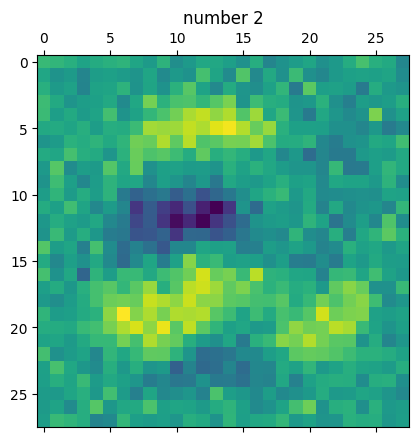

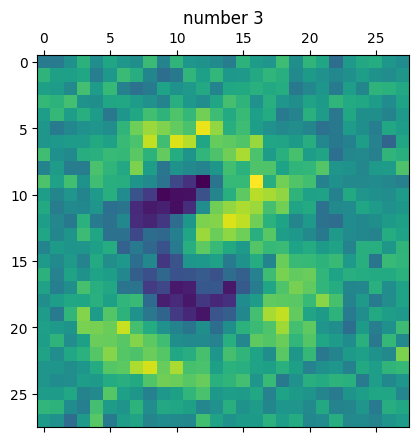

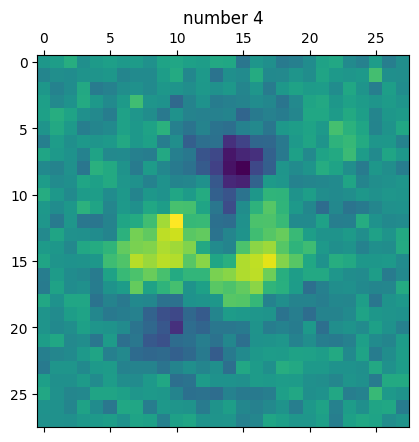

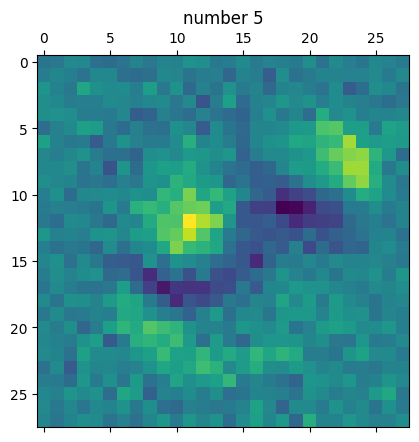

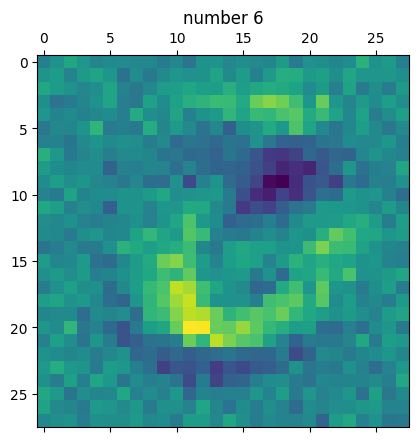

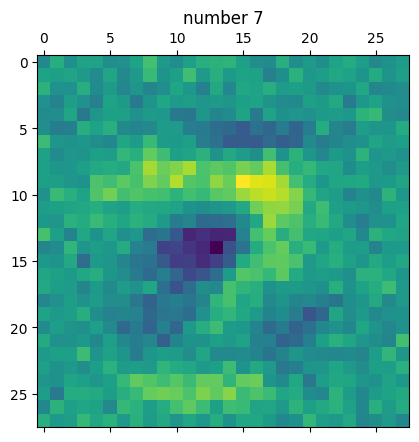

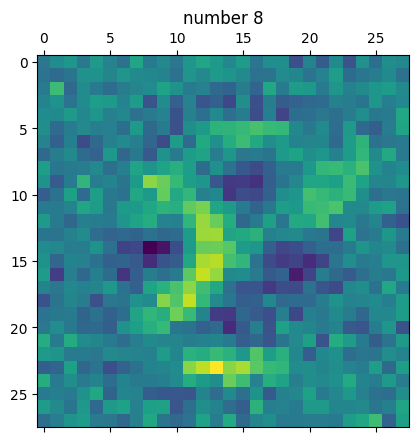

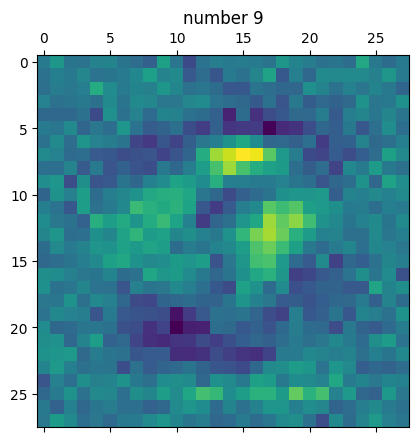

In [39]:
b, A = theta
for i, row in enumerate(A):
    plt.matshow(row.reshape(28, 28)) #, interpolation='bilinear')
    plt.title(f'number {i}')
    plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk.

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [41]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [43]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
import itertools

def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for (m, n), k in zip(itertools.pairwise(sizes), keys)]

layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt.

In [44]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [45]:
# This works on single examples
preds = predict(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2953994 -2.2987492 -2.2974277 -2.318979  -2.3008723 -2.3090346
 -2.3071167 -2.3012722 -2.3021984 -2.2950432]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni.

In [46]:
try:
  preds = predict(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [47]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [51]:
n_targets = 10

In [48]:
def y_pred_true(f, params, dataset):
    y_pred = []
    y_true = []
    for example in tqdm(dataset.batch(256).as_numpy_iterator()):
        images, targets = example['image'], example['label']
        y_pred.append(f(params, images).argmax(axis=-1))
        y_true.append(targets)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return {'y_pred': y_pred, 'y_true': y_true}

def accuracy(f, params, dataset):
    y = y_pred_true(f, params, dataset)
    acc = (y['y_pred'] == y['y_true']).astype(np.float_).mean()
    # n = len(y['y_pred'])
    return acc

def loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return jax.tree.map(lambda p, g: p - step_size * g, params, grads)


Konstansok:

In [49]:
step_size = 0.1
num_epochs = 8
batch_size = 128


In [52]:
import time

lr = jnp.array(step_size)
for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(batched_predict, params, train)
  test_acc = accuracy(batched_predict, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 6.40 sec
Training set accuracy 0.87442
Test set accuracy 0.8776


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 0.60 sec
Training set accuracy 0.90624
Test set accuracy 0.9054


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 0.97 sec
Training set accuracy 0.93312
Test set accuracy 0.93


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 0.54 sec
Training set accuracy 0.94504
Test set accuracy 0.939


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 1.20 sec
Training set accuracy 0.95706
Test set accuracy 0.9527


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 1.17 sec
Training set accuracy 0.96594
Test set accuracy 0.9599


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 0.60 sec
Training set accuracy 0.96722
Test set accuracy 0.9596


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 1.28 sec
Training set accuracy 0.97538
Test set accuracy 0.9666


In [53]:
train_y = y_pred_true(batched_predict, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4886,0,12,1,2,8,10,3,6,9
1,1,5546,18,11,9,8,6,22,29,13
2,7,16,4834,43,2,5,0,32,9,0
3,2,8,18,4908,1,29,0,4,21,13
4,6,7,14,1,4780,13,16,27,12,85
5,4,2,1,47,1,4339,8,1,8,10
6,28,9,11,2,16,43,4879,0,17,1
7,1,6,21,16,3,3,0,5055,2,24
8,23,17,26,67,4,39,11,7,4760,33


In [54]:
test_y = y_pred_true(batched_predict, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,935,0,2,2,1,7,2,1,2,3
1,0,1102,5,1,2,1,2,1,12,5
2,1,7,969,7,2,2,0,7,1,1
3,0,4,5,972,0,7,0,3,7,7
4,2,3,5,1,971,5,11,3,5,24
5,2,0,0,9,0,862,2,0,0,0
6,6,2,3,0,3,8,969,0,9,0
7,0,4,6,3,2,3,0,1027,2,7
8,10,7,4,18,0,10,2,1,931,4


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.



In [58]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [ ]:
hk.MaxPool?

Init signature:
hk.MaxPool(
    window_shape: Union[int, collections.abc.Sequence[int]],
    strides: Union[int, collections.abc.Sequence[int]],
    padding: str,
    channel_axis: Optional[int] = -1,
    name: Optional[str] = None,
)
Docstring:     
Max pool.

Equivalent to partial application of :func:`max_pool`.
Init docstring:
Max pool.

Args:
  window_shape: Shape of the pooling window, same rank as value.
  strides: Strides of the pooling window, same rank as value.
  padding: Padding algorithm. Either ``VALID`` or ``SAME``.
  channel_axis: Axis of the spatial channels for which pooling is skipped.
  name: String name for the module.
File:           ~/.config/jupyterlab-desktop/jlab_server/envs/python3.10/lib/python3.10/site-packages/haiku/_src/pool.py
Type:           ModuleMetaclass
Subclasses:     


In [ ]:
hk.transform?

Signature: hk.transform(f, *, apply_rng=True) -> haiku._src.transform.Transformed
Docstring:
Transforms a function using Haiku modules into a pair of pure functions.

For a function ``out = f(*a, **k)`` this function returns a pair of two pure
functions that call ``f(*a, **k)`` explicitly collecting and injecting
parameter values::

    params = init(rng, *a, **k)
    out = apply(params, rng, *a, **k)

Note that the ``rng`` argument is typically not required for ``apply`` and
passing ``None`` is accepted.

The first thing to do is to define a :class:`Module`. A module encapsulates
some parameters and a computation on those parameters:

>>> class MyModule(hk.Module):
...   def __call__(self, x):
...     w = hk.get_parameter("w", [], init=jnp.zeros)
...     return x + w

Next, define some function that creates and applies modules. We use
:func:`transform` to transform that function into a pair of functions that
allow us to lift all the parameters out of the function (``f.init``) and
appl

In [56]:
def lenet(x):
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Conv2D(64, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(128)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(n_targets)(x)
    x = jax.nn.log_softmax(x)
    return x


In [60]:
param_init, lenet_apply = hk.transform(lenet)
def lenet_fn(params, images):
    return lenet_apply(params, None, images)

In [61]:
key = jax.random.PRNGKey(0)
params = param_init(key, image[:10])

In [62]:
lenet_apply(params, None, image[:1])

Array([[-2.4083662, -2.1603966, -2.331704 , -2.5491571, -2.2276087,
        -2.2106545, -2.1173046, -2.474362 , -2.370628 , -2.2626748]],      dtype=float32)

In [64]:

def lenet_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = lenet_apply(params, None, images)
  return -jnp.mean(preds * targets)*n_targets

@jit
def lenet_update(params, x, y, step_size):
  grads = grad(lenet_loss)(params, x, y)
  return jax.tree.map(lambda p, g: p - step_size * g, params, grads)


In [65]:
import time

lr = jnp.array(step_size)

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.cache().shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = lenet_update(params, x, y, lr)
  lr = lr*0.9
  epoch_time = time.time() - start_time

  train_acc = accuracy(lenet_fn, params, train)
  test_acc = accuracy(lenet_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0 in 3.18 sec
Training set accuracy 0.97262
Test set accuracy 0.9697


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1 in 0.74 sec
Training set accuracy 0.98192
Test set accuracy 0.978


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2 in 0.96 sec
Training set accuracy 0.98282
Test set accuracy 0.9796


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3 in 0.87 sec
Training set accuracy 0.98914
Test set accuracy 0.9845


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4 in 0.76 sec
Training set accuracy 0.99122
Test set accuracy 0.9854


0it [00:00, ?it/s]

0it [00:08, ?it/s]

0it [00:00, ?it/s]

Epoch 5 in 0.69 sec
Training set accuracy 0.9927
Test set accuracy 0.9853


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6 in 0.74 sec
Training set accuracy 0.99356
Test set accuracy 0.9874


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7 in 0.69 sec
Training set accuracy 0.99458
Test set accuracy 0.9873


In [66]:
train_y = y_pred_true(lenet_fn, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4948,0,0,1,0,1,3,0,2,3
1,2,5595,3,0,7,2,2,3,12,3
2,5,4,4939,7,1,3,1,4,8,0
3,0,0,0,5083,0,12,1,0,3,3
4,0,0,1,0,4834,0,3,2,3,11
5,0,0,0,5,0,4475,6,0,5,3
6,3,0,1,0,0,6,4912,0,1,0
7,3,14,13,11,4,1,0,5197,10,21
8,1,0,1,2,1,5,2,1,4825,5


In [67]:
test_y = y_pred_true(lenet_fn, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

0it [00:00, ?it/s]

Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,950,0,0,0,0,1,1,0,2,1
1,0,1116,2,0,2,0,0,1,1,0
2,0,3,987,4,1,0,1,1,4,0
3,0,0,2,1005,0,5,0,0,5,3
4,1,1,0,0,974,0,3,0,3,2
5,0,0,0,1,0,898,3,0,2,0
6,2,0,0,0,2,1,979,0,1,0
7,0,8,6,1,3,3,0,1051,1,6
8,4,1,1,2,0,2,1,0,947,1
